## Agent Based Model: Training Simulator

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = 100

In [2]:
import sys
sys.path.append("../") # go to parent dir

In [3]:
print(sys.path)

['C:\\Users\\a.poghosyan\\Documents\\training_simulation\\training_batch_run_workflow\\training_simulator\\notebooks', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\python312.zip', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\DLLs', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\Lib', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3', '', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\win32', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\setuptools\\_vendor', '../']


In [4]:
sys.path.append('C:\\Users\\a.poghosyan\\Documents\\training_simulation\\training_batch_run_workflow\\training_simulator\\training_simulator')

<img src="career_pipelineHLD.png" alt="Workforce Pipeline Simulator" width="800"/>

**Inputs**
- Number of iterations
- Number of steps (months)
- Number of trainee
- Course Duration
- Hold Duration
- Capacity 
- Attrition (probability of trainees leaving the pipeline)

**Outputs**
- number of trainees in each course/state at any time step throughout the pipeline.
- average number of trainees on hold at given stage.
- average time spent in hold at given stage per trainee.
- total hold times per trainee.
- average training duration per trainee.
- The confidence intervals


**Advantages**
- Easy to implement and test hypotheses in the absence of aggregate data 
- Extensibility and Flexibility
- Provision of  data driven outcomes on testing different interventions and scenarios.
- Long term forecasting potential.

**Limitations**
- Model cannot capture more granular issues that are highly specific to one or the other stage in the pipeline
- Model is not linked to live data sets and hence only represents a snapshot of when the parameters where last estimated.
- Outputs are stochastic so this can be challenging to validate.


<img src="workflow.png" alt="Aircrew Model Pipeline" width="700"/>

### Modelling Assumptions:


- Modelling all of the Pathways can put additional complexity on implementation and then further to testing as numbers are very small. In the future increments of training simulator model (previously called Drake) we will be looking into adding additional features such as refresher courses that will create loopbacks in the linear pipeline.

- **Course Frequency**:  its variable each year and also sometimes in one month two courses are running in parallel. In this ABM model we will reflect this through the capacity parameter. If two of the same courses are running in parallel we will assume that its one course with higher capacity.

- **Schedule Concept**: ABM  model will allow to schedule courses by months (e.g if course is repeated twice a year then it will run every  6 time steps). The schedule will not be a parameter that users can change.

- **Extra variance**: To add variance to model output the course capacity and duration parameters will be generated randomly from the intervals Int(duration-SD, duration+SD), Int(capacity-SD, capacity+SD). Over the length of simulation this number will remain static fixed. Running new simulation will generate different numbers within allowed interval.

In [5]:
from training_simulator.run import run_batch
from training_simulator.analysis import (
    make_average_path,
    get_agents_data,
    make_time_series,
    make_quantile_path,
)
from training_simulator.stages import INIT
from training_simulator.structure import (
    TraineeBase,
    PipelineModelBase,
    Stage,
    StageManager,
    State,
)

## Simulation

All states start with the same number of pilots in and the same number waiting to progress

In [6]:
steps = 12 * 3
model_params = {"version": "2.1.3",
    "simulation": {"steps": 120, "start_month": 4, "iterations": 5},
    "streaming":1,
    "init_trainees": {
        "stage1": {"progressing": 0, "hold": 0},
        "stage2": {"progressing": 0, "hold": 0},
        "stage3": {"progressing": 0, "hold": 0},
        "stage21": {"progressing": 0, "hold": 0},
        "stage211": {"progressing": 0, "hold": 0},
        "stage22": {"progressing": 0, "hold": 0},
        "stage23": {"progressing": 0, "hold": 0},
        "stage231": {"progressing": 0, "hold": 0},
        "stage31": {"progressing": 0, "hold": 0},
        "stage32": {"progressing": 0, "hold": 0},
        "stage33": {"progressing": 0, "hold": 0},
    },

    "pipeline": {
        "init": {"new_trainees": 10, "input_rate": 1, "time_hold": 120},
        "stage1": {
            "drop_out_progressing": 0.12,
            "drop_out_hold": 0,
            "capacity_progressing": 21,
            "time_progressing": 2,
            "time_hold": 120,
        },
        "stage2": {
            "drop_out_progressing": 0.05,
            "drop_out_stream": 0.6,
            "drop_out_hold": 0,
            "capacity_progressing": 11,
            "time_progressing": 6,
            "time_hold": 120,
        },
        "stage3": {
            "drop_out_progressing": 0.0,
            "drop_out_hold": 0.0,
            "capacity_progressing": 10,
            "time_progressing": 2,
            "time_hold": 120,
        },
        "stage21": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "time_progressing": 13,
            "capacity_progressing": 4,
            "time_hold": 120,
        },
        "stage22": {
            "drop_out_progressing": 0.2,
            "drop_out_hold": 0,
            "capacity_progressing": 4,
            "time_progressing": 10,
            "time_hold": 120,
        },
        "stage23": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 4,
            "time_progressing": 6,
            "pathway_complete": "training_pathway1_complete",
            "time_hold": 120,
        },
        "stage211": {
            "drop_out_progressing": 0.0,
            "drop_out_hold": 0,
            "capacity_progressing": 8,
            "time_progressing": 2,
            "time_hold": 120,
        },
        "stage231": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 4,
            "time_progressing": 8,
            "pathway_complete": "training_pathway2_complete",
            "time_hold": 120,
        },
        "stage31": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 2,
            "time_progressing": 6,
            "pathway_complete": "training_pathway3_complete",
            "time_hold": 120,
        },
        "stage32": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 10,
            "time_progressing": 2,
            "time_hold": 120,
        },
        "stage33": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 8,
            "time_progressing": 2,
            "time_hold": 120,
        },

    },
    "schedule": {
        "stage1": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "stage2": [2, 3, 5, 6, 7, 8, 9, 10, 11],
        "stage3": [1, 3, 4, 6, 7, 9, 11],
        "stage21": [1, 4, 7, 10],
        "stage211": [1, 4, 7, 10],
        "stage22": [2, 3, 4, 6, 7, 9, 10],
        "stage23": [1, 3, 4, 5, 6, 8, 9, 10, 11],
        "stage231": [1, 3, 4, 6, 8, 9, 11, 12],
        "stage31": [3, 7, 11],
        "stage32": [1, 3, 6, 9, 11],
        "stage33": [2, 4, 6, 8, 10, 12]

    },
}



In [7]:
pd.json_normalize(model_params)

,version,streaming,simulation.steps,simulation.start_month,simulation.iterations,init_trainees.stage1.progressing,init_trainees.stage1.hold,init_trainees.stage2.progressing,init_trainees.stage2.hold,init_trainees.stage3.progressing,...,schedule.stage2,schedule.stage3,schedule.stage21,schedule.stage211,schedule.stage22,schedule.stage23,schedule.stage231,schedule.stage31,schedule.stage32,schedule.stage33
0,2.1.3,1,120,4,5,0,0,0,0,0,...,"[2, 3, 5, 6, 7, 8, 9, 10, 11]","[1, 3, 4, 6, 7, 9, 11]","[1, 4, 7, 10]","[1, 4, 7, 10]","[2, 3, 4, 6, 7, 9, 10]","[1, 3, 4, 5, 6, 8, 9, 10, 11]","[1, 3, 4, 6, 8, 9, 11, 12]","[3, 7, 11]","[1, 3, 6, 9, 11]","[2, 4, 6, 8, 10, 12]"


In [8]:
simulation_data = run_batch(model_params)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
sim_dataframe = pd.DataFrame(simulation_data).reset_index()

In [10]:
sim_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556600 entries, 0 to 556599
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           556600 non-null  int64 
 1   RunId           556600 non-null  int64 
 2   iteration       556600 non-null  int64 
 3   Step            556600 non-null  int64 
 4   parameters      556600 non-null  object
 5   career_pathway  556600 non-null  object
 6   stagemap        556600 non-null  int64 
 7   AgentID         556600 non-null  object
 8   Stage           346761 non-null  object
 9   StageId         556600 non-null  object
 10  State           556600 non-null  object
 11  Month_Step      556600 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 51.0+ MB


In [11]:
sim_dataframe.head(5)

,index,RunId,iteration,Step,parameters,career_pathway,stagemap,AgentID,Stage,StageId,State,Month_Step
0,0,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 0.6}, ""stage3...",10,142711851451313613200785134419023272821,stage1,0_22879,progressing,4
1,1,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 0.6}, ""stage3...",10,307630755338688906259571005548194979327,stage1,0_22879,hold,4
2,2,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 0.6}, ""stage3...",10,20515458290407427579028207132366534199,stage1,0_22879,progressing,4
3,3,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 0.6}, ""stage3...",10,1146861573541158476898829495200979205,stage1,0_22879,progressing,4
4,4,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 0.6}, ""stage3...",10,246519623662913072283042422618736081090,stage1,0_22879,hold,4


In [12]:
sim_dataframe['Month_Step'].value_counts()

Month_Step
4     56100
3     48000
2     47500
1     47000
12    46500
11    46000
10    45500
9     45000
8     44500
7     44000
6     43500
5     43000
Name: count, dtype: int64

In [13]:
a_df = get_agents_data(simulation_data)

In [14]:
duplicates = a_df.groupby(['RunId', 'AgentID', 'Stage', 'State']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]


In [15]:
duplicates

,RunId,AgentID,Stage,State,count
2,0,100323037955055302593358625615761564046,stage1,progressing,2
3,0,100323037955055302593358625615761564046,stage3,hold,2
4,0,100323037955055302593358625615761564046,stage3,progressing,2
5,0,100323037955055302593358625615761564046,stage32,hold,3
6,0,100323037955055302593358625615761564046,stage32,progressing,3
...,...,...,...,...,...
44335,4,99326934476487362017553077807677795231,stage22,left,24
44336,4,99326934476487362017553077807677795231,stage22,progressing,10
44337,4,99534334806604548630236863105690201329,stage23,progressing,5
44339,4,99534334806604548630236863105690201329,stage231,progressing,8


In [16]:
a_df.shape

(556600, 5)

In [18]:
#drop dulplicated for left_raf
left_df = a_df.loc[a_df['State']=='left']

left_df = left_df.drop_duplicates(subset=['RunId', 'AgentID', 'Stage', 'State'])

In [20]:
left = make_average_path(left_df, model_params)

In [21]:
left.tail(10)

State   left                                                                
Stage stage1 stage21 stage22 stage23 stage231 stage2 stage33 stage32 stage31
Step                                                                        
111      3.0     0.0     1.8     0.2      0.2    1.2     0.4     0.0     0.0
112      2.6     0.0     0.0     0.0      0.4    1.0     0.2     0.2     0.2
113      2.4     0.0     0.0     0.0      0.4    0.4     0.0     0.4     0.4
114      2.4     0.2     0.0     0.2      0.0    0.2     0.2     0.2     0.0
115      0.8     0.0     0.0     0.6      0.0    0.4     0.0     0.2     0.0
116      2.4     0.0     0.0     0.0      0.0    0.0     0.6     0.0     0.0
117      1.6     0.0     0.0     0.2      0.2    0.0     0.0     0.0     0.0
118      1.4     0.0     0.0     0.0      0.0    0.0     0.2     0.4     0.2
119      2.0     0.0     0.0     0.2      0.2    0.0     0.0     0.0     0.0
120      3.0     0.0     0.0     0.0      0.0    0.0     0.0     0.0     0.0

In [22]:
a_df.head(10)

,RunId,Step,AgentID,Stage,State
0,0,0,142711851451313613200785134419023272821,stage1,progressing
1,0,0,307630755338688906259571005548194979327,stage1,hold
2,0,0,20515458290407427579028207132366534199,stage1,progressing
3,0,0,1146861573541158476898829495200979205,stage1,progressing
4,0,0,246519623662913072283042422618736081090,stage1,hold
5,0,0,137102053410765948246531408649064159845,stage1,progressing
6,0,0,128758169736937044107355070354168344262,stage1,progressing
7,0,0,163247815864818345988812853047222642774,stage1,hold
8,0,0,84856819643756479431166993927171936531,stage1,progressing
9,0,0,230194002774437177978914212143480160502,stage1,progressing


In [23]:
a_df['time_stage_state'] =a_df.groupby(['RunId','AgentID','Stage','State']).cumcount()+1

In [24]:
a_df.head()

,RunId,Step,AgentID,Stage,State,time_stage_state
0,0,0,142711851451313613200785134419023272821,stage1,progressing,1.0
1,0,0,307630755338688906259571005548194979327,stage1,hold,1.0
2,0,0,20515458290407427579028207132366534199,stage1,progressing,1.0
3,0,0,1146861573541158476898829495200979205,stage1,progressing,1.0
4,0,0,246519623662913072283042422618736081090,stage1,hold,1.0


In [25]:
def make_stage_state_times_table(agent_data: pd.DataFrame) -> pd.DataFrame:
    stage_state_df =pd.DataFrame(
        agent_data.groupby(["RunId", "Step", "Stage", "State"])['time_stage_state'].mean()
    ).reset_index()
    return stage_state_df.pivot(
        index=["RunId", "Step"], columns=["State", "Stage"], values="time_stage_state"
    ).fillna(0)
    

In [26]:
from typing import List
def make_average_times_path(agent_data) -> pd.DataFrame:
    time_series_data_df = make_stage_state_times_table(agent_data)
    return time_series_data_df.groupby("Step").mean()


In [27]:
average_progressing = make_average_times_path(a_df)

In [28]:
a_df.head()

,RunId,Step,AgentID,Stage,State,time_stage_state
0,0,0,142711851451313613200785134419023272821,stage1,progressing,1.0
1,0,0,307630755338688906259571005548194979327,stage1,hold,1.0
2,0,0,20515458290407427579028207132366534199,stage1,progressing,1.0
3,0,0,1146861573541158476898829495200979205,stage1,progressing,1.0
4,0,0,246519623662913072283042422618736081090,stage1,hold,1.0


In [29]:
average_progressing

State progressing      hold progressing      hold progressing       hold  \
Stage        init    stage1      stage1    stage2      stage2    stage21   
Step                                                                       
0             1.0  1.000000    1.000000  1.000000    1.000000   1.000000   
1             1.0  1.090909    1.635129  2.000000    2.000000   2.000000   
2             1.0  1.000000    2.131150  1.866078    2.457518   3.000000   
3             1.0  1.000000    1.460716  1.295162    2.921080   4.000000   
4             1.0  1.000000    1.461300  1.832736    3.418033   5.000000   
...           ...       ...         ...       ...         ...        ...   
116           1.0  1.000000    1.461404  1.000000    3.407310  33.276754   
117           1.0  1.000000    1.472515  1.489091    3.915556  33.732975   
118           1.0  1.000000    1.483626  2.004848    4.461069  33.663455   
119           1.0  1.000000    1.473099  1.464444    3.342735  34.057110   
120           1.0  1.000000    1.454868  1.000000    2.922133  34.267690   

State progressing      hold progressing      hold  ...    left             \
Stage     stage21  stage211    stage211   stage22  ... stage21    stage22   
Step                                               ...                      
0        1.000000  1.000000    1.000000  1.000000  ...    0.00   0.000000   
1        1.827536  0.000000    1.666667  2.000000  ...    0.80   1.000000   
2        2.740000  1.000000    2.666667  3.000000  ...    1.80   1.833333   
3        3.648485  1.654545    3.000000  4.000000  ...    2.80   2.833333   
4        3.700000  2.566667    1.000000  0.000000  ...    3.80   3.833333   
...           ...       ...         ...       ...  ...     ...        ...   
116      6.520000  1.000000    2.000000  1.000000  ...   61.14  61.283333   
117      7.520000  2.000000    3.000000  1.536667  ...   62.14  62.283333   
118      7.000000  0.000000    1.000000  2.320000  ...   63.14  63.283333   
119      6.480000  1.000000    2.000000  1.893333  ...   64.14  64.283333   
120      7.480000  2.000000    3.000000  1.066667  ...   65.14  65.283333   

State                                                            complete  \
Stage    stage23   stage231  stage2    stage33 training_pathway2_complete   
Step                                                                        
0       0.000000   0.000000   0.000   0.000000                   0.000000   
1       0.600000   0.800000   0.400   0.200000                   0.000000   
2       1.300000   1.600000   1.200   0.733333                   1.000000   
3       2.200000   2.600000   2.050   1.633333                   2.000000   
4       3.200000   3.600000   2.720   2.533333                   2.066667   
...          ...        ...     ...        ...                        ...   
116    62.900117  62.173946  60.272  60.693056                  77.950917   
117    63.221032  62.237682  61.272  61.693056                  78.284852   
118    64.221032  63.237682  62.272  61.972467                  79.284852   
119    64.317222  63.603472  63.272  62.972467                  79.471317   
120    65.317222  64.603472  64.272  63.972467                  80.471317   

State                                  left             
Stage training_pathway3_complete    stage32    stage31  
Step                                                    
0                       0.000000   0.000000   0.000000  
1                       0.000000   0.400000   0.000000  
2                       1.000000   0.800000   0.000000  
3                       2.000000   1.200000   0.000000  
4                       3.000000   1.700000   0.200000  
...                          ...        ...        ...  
116                    64.099928  61.729651  60.092857  
117                    65.099928  62.729651  61.092857  
118                    64.273020  62.709748  60.475000  
119                    65.273020  63.709748  61.475000  
120                    66.273020  64

In [30]:
a_df

,RunId,Step,AgentID,Stage,State,time_stage_state
0,0,0,142711851451313613200785134419023272821,stage1,progressing,1.0
1,0,0,307630755338688906259571005548194979327,stage1,hold,1.0
2,0,0,20515458290407427579028207132366534199,stage1,progressing,1.0
3,0,0,1146861573541158476898829495200979205,stage1,progressing,1.0
4,0,0,246519623662913072283042422618736081090,stage1,hold,1.0
...,...,...,...,...,...,...
556595,4,120,10294270041255859912026213045607896128,init,progressing,1.0
556596,4,120,196320145201498995475493142703721316359,init,progressing,1.0
556597,4,120,63182828161561690071582066844654429477,init,progressing,1.0
556598,4,120,295296528689490305290526925557607949510,init,progressing,1.0


In [34]:
a_df.to_csv('trainee_journey.csv', index=False)

In [34]:
n_df = make_average_path(a_df.loc[a_df['State']!='left'], model_params)

In [37]:
n_df = make_average_path(a_df, model_params)

In [38]:
n_df.shape

(121, 34)

In [39]:
n_df.head(10)

State progressing   hold progressing   hold progressing    hold progressing  \
Stage        init stage1      stage1 stage2      stage2 stage21     stage21   
Step                                                                          
0            10.0   22.0        42.0   18.0        33.0    10.0        20.0   
1            10.0   11.0        57.6   18.0        32.0     6.0        23.2   
2            10.0   10.0        45.8   16.2        40.6     6.0        15.4   
3            10.0   10.0        18.6   23.0        51.0     6.0        11.4   
4            10.0   10.0        18.6   16.4        61.2     2.0        15.4   
5            10.0   10.0        18.2   10.6        72.0     2.0        15.4   
6            10.0   10.0        18.6    4.6        72.0     7.2        15.4   
7            10.0   10.0        19.4    5.0        76.6     3.2        19.4   
8            10.0   10.0        19.4    5.0        61.8    13.6        19.4   
9            10.0   10.0        19.2   10.4        41.8    23.8        19.4   

State     hold progressing    hold  ...    left                           \
Stage stage211    stage211 stage22  ... stage21 stage22 stage23 stage231   
Step                                ...                                    
0          2.0         4.0    12.0  ...     0.0     0.0     0.0      0.0   
1          0.0         6.0     8.0  ...     0.8     5.0     0.6      1.2   
2          7.6         6.0     8.0  ...     1.0     6.0     1.8      2.0   
3         11.6         2.0     4.0  ...     1.0     6.0     2.0      2.0   
4          3.6         8.0     0.0  ...     1.0     6.0     2.0      2.0   
5          3.6         8.0     0.0  ...     1.0     6.0     2.0      2.0   
6          3.6         8.0     3.2  ...     1.0     6.0     2.0      2.0   
7          0.0         3.6     0.0  ...     1.0     6.0     2.0      2.0   
8          0.0         3.6     5.4  ...     1.0     6.0     2.0      2.0   
9          0.0         3.6    12.4  ...     1.0     6.0     2.0      2.0   

State                                  complete                             \
Stage stage2 stage33 training_pathway2_complete training_pathway3_complete   
Step                                                                         
0        0.0     0.0                        0.0                        0.0   
1        1.0     0.4                        0.0                        0.0   
2        3.4     1.0                        3.8                        2.0   
3        4.0     1.6                        3.8                        2.0   
4        4.8     1.8                        7.2                        2.0   
5        5.0     1.8                       10.4                        2.0   
6        5.0     1.8                       14.4                        3.8   
7        5.0     1.8                       14.4                        3.8   
8        5.0     1.8                       18.2                        3.8   
9        5.0     1.8                       26.0                        3.8   

State    left          
Stage stage32 stage31  
Step                   
0         0.0     0.0  
1         0.4     0.0  
2         0.4     0.0  
3         0.4     0.0  
4         1.0     0.2  
5         1.6     0.4  
6         1.6     0.6  
7         2.4     0.6  
8         2.6     0.8  
9         3.0     0.8  

[10 rows x 34 columns]

Text(0.5, 0, 'Steps (months)')

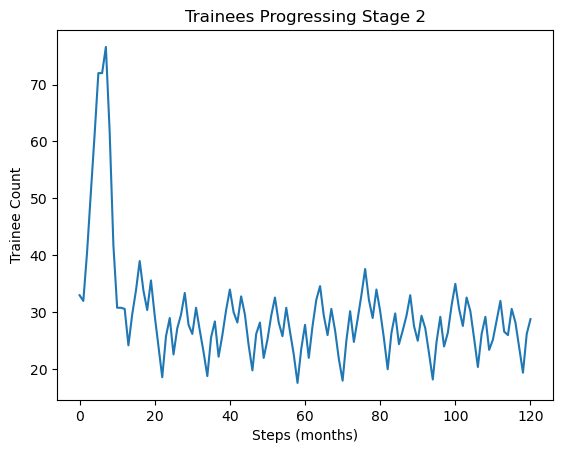

In [41]:
ax = n_df.progressing.stage2.plot(title='Trainees Progressing Stage 2')
ax.set_ylabel("Trainee Count")
ax.set_xlabel("Steps (months)")

Text(0.5, 0, 'Steps (months)')

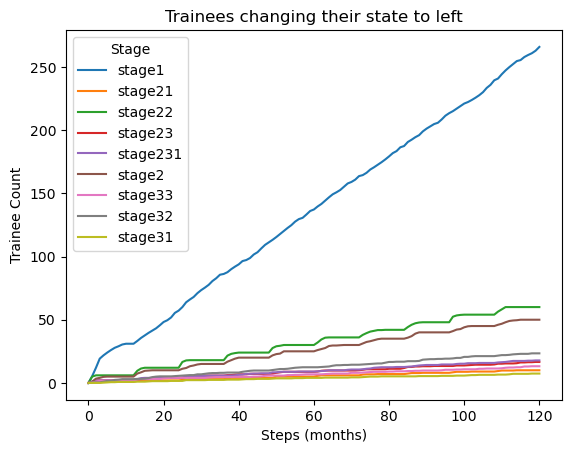

In [43]:
ax = n_df.left.plot(title='Trainees changing their state to left')
ax.set_ylabel("Trainee Count")
ax.set_xlabel("Steps (months)")

Text(0.5, 24.0, 'Steps (months)')

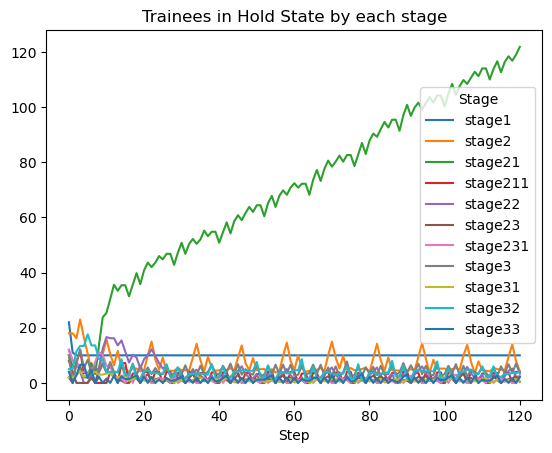

In [44]:
n_df.hold.plot(title='Trainees in Hold State by each stage')
ax.set_ylabel("Trainee Count")
ax.set_xlabel("Steps (months)")

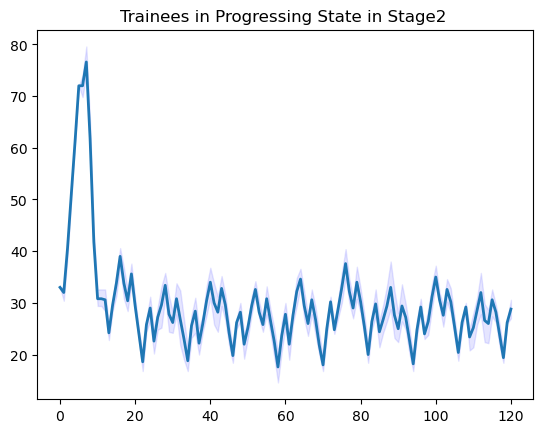

In [46]:
# Select stage
state = "progressing"
stage = "stage2"


# Compute curves of interest:
mean_path = make_average_path(simulation_data, model_params)[state][stage]
under_line_quantile = make_quantile_path(simulation_data, 0.1)[state][stage]
over_line_quantile = make_quantile_path(simulation_data, 0.9)[state][stage]

# Plotting:
plt.plot(mean_path, linewidth=2)  # mean curve.
plt.title('Trainees in Progressing State in Stage2 ')
plt.fill_between(
    mean_path.index, under_line_quantile, over_line_quantile, color="b", alpha=0.1
)